In [1]:
from transformers import DistilBertModel, DistilBertTokenizer, Trainer, TrainingArguments, DistilBertForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import torch.nn as nn
from torch.nn import functional as f
import numpy as np
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import pandas as pd
import pytorch_lightning as pl
import orjson
import seaborn as sns
from matplotlib import pyplot as plt

from datasets import Dataset, DatasetDict
from datasets import load_metric
from torchmetrics import functional as F

# Build Model

In [2]:
# Hmm cant use custom model with trainer unless i create my own custom trainer
class DistilFakeBert(nn.Module):
    def __init__(self):
        super(DistilFakeBert, self).__init__()
        
        self.distil_bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.output = nn.Linear(256, 2)
        
    def forward(self, input_ids, attention_mask):
        embeddings = self.distil_bert(
            input_ids, attention_mask=attention_mask
        )[0][:, 0]
        embeddings = self.fc1(embeddings)
        embeddings = self.relu(embeddings)
        embeddings = self.dropout(embeddings)
        output = self.output(embeddings)
        
        return output

In [3]:
# model = DistilFakeBert()
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

# Load data and transform

In [4]:
df = pd.read_csv('data_text/news.csv')

In [5]:
label_index = {
    'REAL':1,
    'FAKE': 0
}
df['label'] = df['label'].apply(lambda x: label_index[x])

In [6]:
text = df['text'].tolist()
labels = df['label'].tolist()

In [7]:
train_text, valid_text, train_label, valid_label = train_test_split(text, labels, stratify=labels, random_state=2021, test_size=0.3)
valid_text, test_text, valid_label, test_label = train_test_split(valid_text, valid_label, stratify=valid_label, random_state=2021, test_size=0.5)

In [8]:
data = {
    'train': Dataset.from_dict({
        'text': train_text,
        'label': train_label
    }),
    'valid': Dataset.from_dict({
        'text': valid_text,
        'label': valid_label
    }),
    'test': Dataset.from_dict({
        'text': test_text,
        'label': test_label
    })
}

In [9]:
dataset = DatasetDict(data)

In [10]:
# Write a tokenizer function
def tokenize_data(data):
    return tokenizer(
        data['text'], truncation=True, max_length=300, padding='max_length', 
        add_special_tokens=True, 
    )

In [11]:
encoded_dataset = dataset.map(tokenize_data, batched=True)

In [12]:
columns_to_return = ['input_ids', 'attention_mask', 'label']
encoded_dataset.set_format(type='torch', columns=columns_to_return)
encoded_dataset = encoded_dataset.remove_columns('text')

In [13]:
train_args = TrainingArguments(
    'distil-classifier',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    report_to='none',
    logging_steps=100
)

In [14]:
metric = load_metric('accuracy')

In [15]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [16]:
trainer = Trainer(
    model, train_args, train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['valid'], tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [17]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,0.289200,0.144289,0.953684,6.490400,146.369000
2,0.118700,0.130558,0.957895,6.476800,146.678000
3,0.044300,0.133363,0.960000,6.493800,146.293000


TrainOutput(global_step=417, training_loss=0.12795546272104022, metrics={'train_runtime': 299.9076, 'train_samples_per_second': 1.39, 'total_flos': 1603143977436000.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 1485656064, 'init_mem_gpu_alloc_delta': 268953088, 'init_mem_cpu_peaked_delta': 206442496, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 188301312, 'train_mem_gpu_alloc_delta': 1087688704, 'train_mem_cpu_peaked_delta': 347660288, 'train_mem_gpu_peaked_delta': 5488539648})

In [18]:
trainer.evaluate()

{'eval_loss': 0.1333625465631485,
 'eval_accuracy': 0.96,
 'eval_runtime': 6.4477,
 'eval_samples_per_second': 147.339,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': -81920,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 81920,
 'eval_mem_gpu_peaked_delta': 483446272}

# Model evaluation

In [19]:
preds = trainer.predict(encoded_dataset['test'])

In [20]:
y_pred = preds.predictions.argmax(axis=1)

In [21]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       475
           1       0.94      0.98      0.96       476

    accuracy                           0.96       951
   macro avg       0.96      0.96      0.96       951
weighted avg       0.96      0.96      0.96       951



<AxesSubplot:>

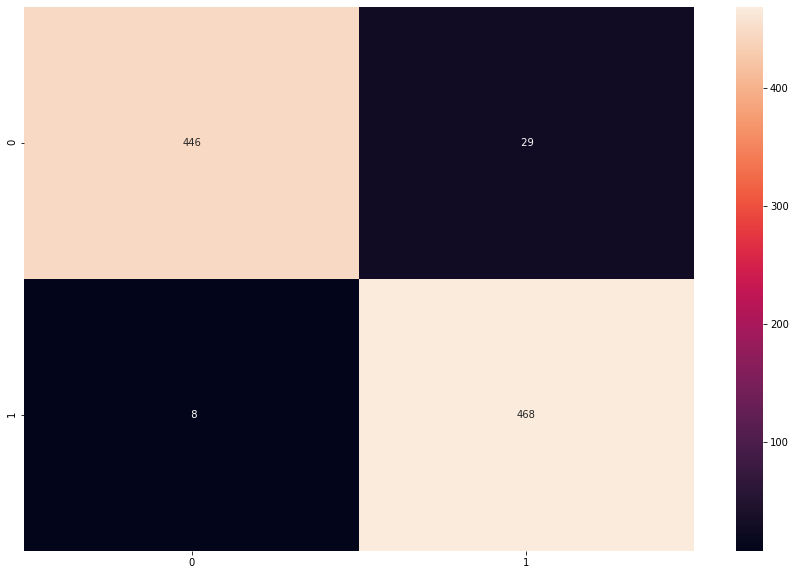

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(test_label, y_pred), annot=True, fmt='3')

In [23]:
print('MCC: {}'.format(round(matthews_corrcoef(test_label, y_pred) * 100, 2)))

MCC: 92.31
